In [1]:
base_dir = '/glade/work/kjmayer/research/catalyst/S2S_ocn_lnd_atm/'
import xarray as xr
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torchinfo
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from model.train_utils import NeuralNetwork
import utils.utils
from utils.utils import get_config
from utils.utils import prepare_device
from trainer.trainer import Trainer
import model.metrics as module_metric
from data_prep.data_loader import GetXData, GetYData, CustomDataset,lead_shift, concat_input

In [2]:
# torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()
# torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-80GB'

In [3]:
config = get_config("exp_1")

torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
torch.backends.cudnn.deterministic = True

In [4]:
LEAD = config["data_loader"]["lead"][0] # will loop over this for training eventually
trainfinames = config["data_loader"]["anommems_finames"][0:6]
valfinames = config["data_loader"]["anommems_finames"][6:8]

# xtrain, xtrainmean, xtrainstd, xtrainmin, xtrainmax
xtrain, xtrainmin, xtrainmax = GetXData(dir=config["data_loader"]["base_dir"],
                                      var=config["data_loader"]["atm_var"],
                                      finames=trainfinames,
                                      train=True,
                                      climo=False)[0]
# xtrain = xtrain.stack(l=('lat','lon'))
xtrain_shift = lead_shift(xtrain, lead=LEAD, forward=False)

#ytrain, ytrainmean, ytrainstd, ytrainmax, ytrainmin
ytrain, ytrainmax, ytrainmin = GetYData(dir=config["data_loader"]["base_dir"],
                                       var=config["data_loader"]["atm_var"],
                                       finames=trainfinames,
                                       train=True,
                                       norm=True,
                                       )[0]

ytrain = ytrain.sel(lat=slice(29,61))
ytrain = ytrain.stack(l=('lat','lon'))
ytrain_shift = lead_shift(ytrain, lead=LEAD, forward=True)

xval = GetXData(dir=config["data_loader"]["base_dir"],
                var=config["data_loader"]["atm_var"],
                finames=valfinames,
                train=False,
                # trainmean=xtrainmean,
                # trainstd=xtrainstd,
                trainmin=xtrainmin,
                trainmax=xtrainmax,
                climo=False)[0]
# 
xval_shift = lead_shift(xval, lead=LEAD, forward=False)

yval = GetYData(dir=config["data_loader"]["base_dir"],
                var=config["data_loader"]["atm_var"],
                finames=trainfinames,
                train=False,
                # trainmean=ytrainmean,
                # trainstd=ytrainstd,
                norm=True,
                trainmax=ytrainmax,
                trainmin=ytrainmin,
                )[0]

yval = yval.sel(lat=slice(29,61))
yval = yval.stack(l=('lat','lon'))
yval_shift = lead_shift(yval, lead=LEAD, forward=True)


# # climo (same for train, val, and test --> basically a DOY encoder)
# xclimo, climomin, climomax = GetXData(dir = config["data_loader"]["base_dir"],
#                                      var = config["data_loader"]["atm_var"],
#                                      finames = config["data_loader"]["climo_finame"],
#                                      train = False, # MUST ALWAYS BE False FOR CLIMO
#                                      climo = True)[0]
# # climo appended to same length as training
# xclimo = xclimo.rename({'dayofyear': 'time'})
# xclimo_train = xr.concat([xclimo]*int(xtrain.shape[0]/365),dim='mem')
# xclimo_train = xclimo_train.stack(s=('mem','time')).transpose('s', 'lat', 'lon').reset_index(['s'])
# xclimo_train_shift = lead_shift(xclimo_train,lead=LEAD,forward=False)

# # climo appended to same length as validation
# xclimo_val = xr.concat([xclimo]*int(xval.shape[0]/365),dim='mem')
# xclimo_val = xclimo_val.stack(s=('mem','time')).transpose('s', 'lat', 'lon').reset_index(['s'])
# xclimo_val_shift = lead_shift(xclimo_val,lead=LEAD,forward=False)

/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/xarray/core/variable.py:1546: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/xarray/core/variable.py:1546: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shap

In [5]:
# Xtrain = concat_input(xtrain_shift,xclimo_train_shift,dim_name='features').values
Xtrain = xtrain_shift.expand_dims(dim={"features": 1},axis=1).values
del xtrain_shift#,xclimo_train_shift
# Xval = concat_input(xval_shift,xclimo_val_shift,dim_name='features').values
Xval = xval_shift.expand_dims(dim={"features": 1},axis=1).values
del xval_shift#,xclimo_val_shift
Ytrain = ytrain_shift.values
del ytrain_shift
Yval = yval_shift.values
del yval_shift

In [6]:
## Prep training and validation for ANN
config = get_config("exp_1")
training_data = CustomDataset(Xtrain,Ytrain) #xtrain, ytrain need to be numpy, not xarray
val_data = CustomDataset(Xval,Yval)

#[batch_size,channels,lat,lon]
train_dataloader = DataLoader(training_data,batch_size = config["data_loader"]["batch_size"],shuffle=True)
val_dataloader  = DataLoader(val_data,batch_size = config["data_loader"]["batch_size"],shuffle=True)

In [7]:
# check shapes
# for input, output in training_data:
#     print(np.shape(input))
#     print(np.shape(output))
#     break

train_features, train_labels = next(iter(train_dataloader))
print(np.shape(train_features))
print(np.shape(train_labels))

torch.Size([32, 1, 96, 144])
torch.Size([32, 2448])


In [41]:
## create NN architecture
config = get_config("exp_1")
# print(config["arch_atm"])
device = prepare_device(config["device"])
model = NeuralNetwork(config=config["arch_atm"])

## grab optimizer and loss 
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
# use yval.lat so that the lat dimension is the same as latxlon
latitude_weights = torch.tensor(np.cos(np.deg2rad(yval.lat)).values, device=device)
#plt.imshow(np.cos(np.deg2rad(yval.lat)).unstack('l'))
criterion = getattr(module_metric, config["criterion"])(latitude_weights)
#criterion = getattr(torch.nn, config["criterion"])() # not custom

metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

## Build the trainer
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data=train_dataloader,
    validation_data=val_dataloader,
    device=device,
    config=config,
)

# Visualize the model
torchinfo.summary(
    model,
    input_size=(config["data_loader"]["batch_size"], 1, 96, 144),
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

#Train the Model
model.to(device)
trainer.fit()

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 1.8 GB
Cached:    6.0 GB
using device:  cuda
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NeuralNetwork                            [32, 1, 96, 144]          [32, 2448]                --
├─CircularPad2d: 1-1                     [32, 1, 96, 144]          [32, 1, 96, 154]          --
├─Sequential: 1-2                        [32, 1, 96, 154]          [32, 8, 48, 77]           --
│    └─Sequential: 2-1                   [32, 1, 96, 154]          [32, 8, 48, 77]           --
│    │    └─Conv2d: 3-1                  [32, 1, 96, 154]          [32, 8, 96, 154]          208
│    │    └─ReLU: 3-2                    [32, 8, 96, 154]          [32, 8, 96, 154]          --
│    │    └─MaxPool2d: 3-3               [32, 8, 96, 154]          [32, 8, 48, 77]           --
├─Flatten: 1-3                        

dict_keys(['epoch', 'loss', 'val_loss', 'MAE', 'MSE', 'val_MAE', 'val_MSE'])


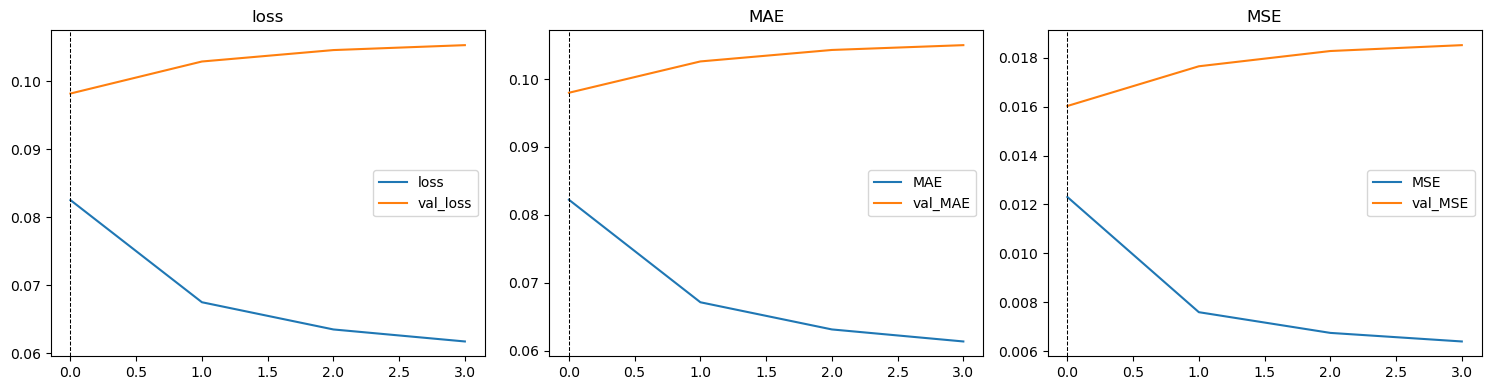

In [36]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
        x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

In [37]:
val_pred = model.predict(dataset=val_data, batch_size=config["data_loader"]["batch_size"], device=device)

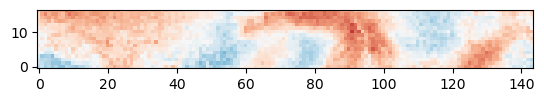

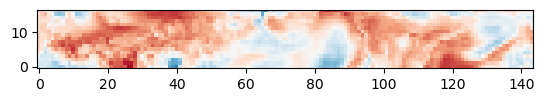

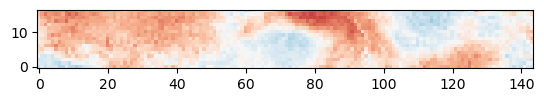

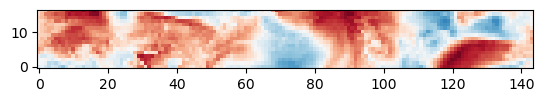

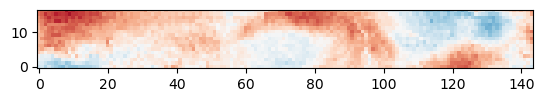

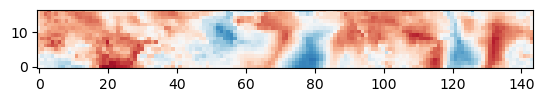

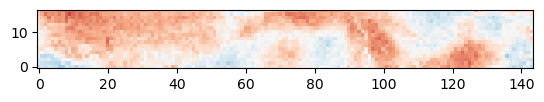

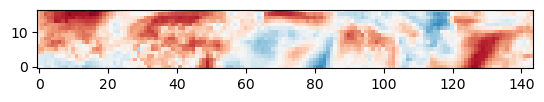

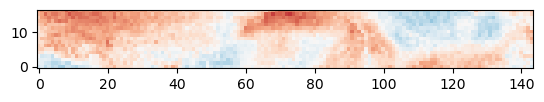

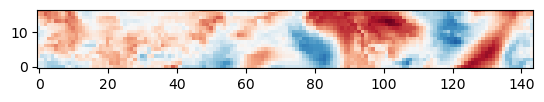

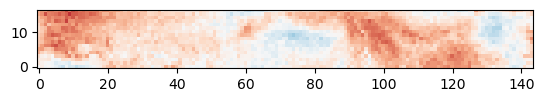

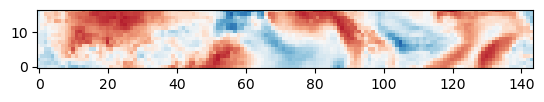

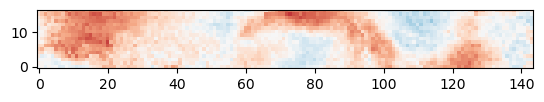

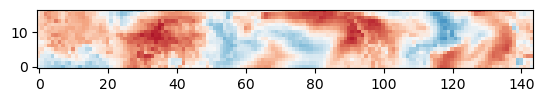

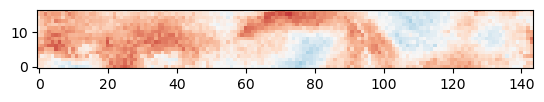

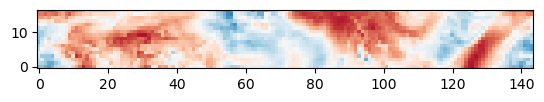

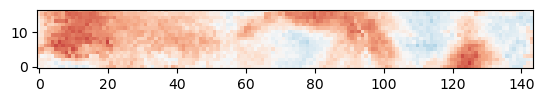

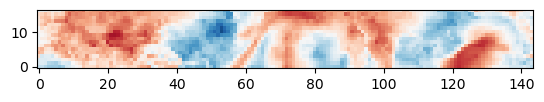

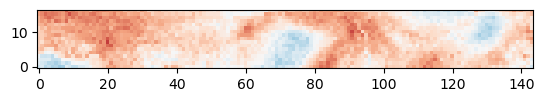

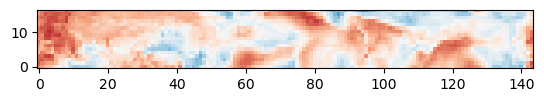

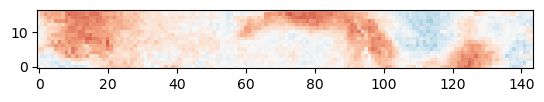

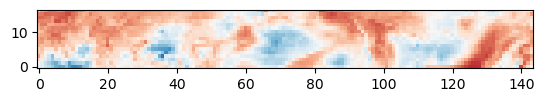

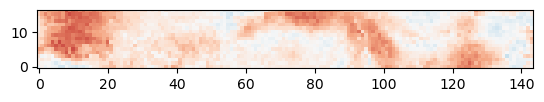

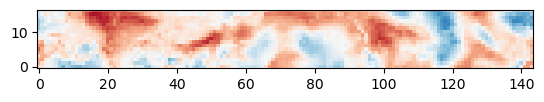

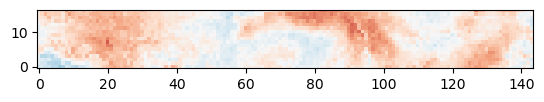

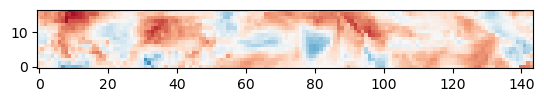

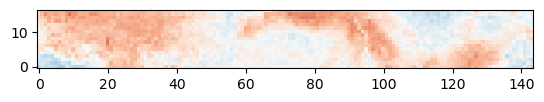

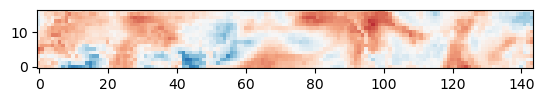

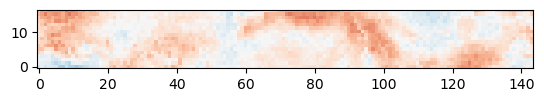

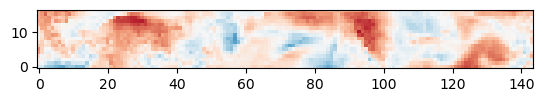

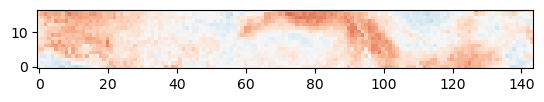

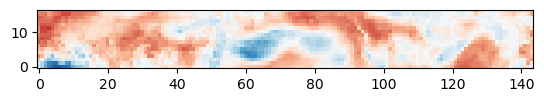

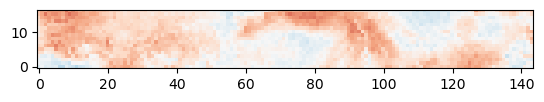

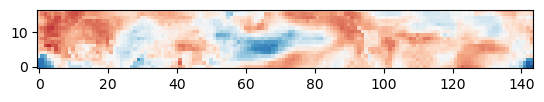

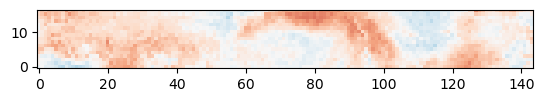

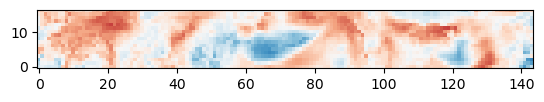

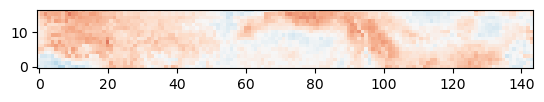

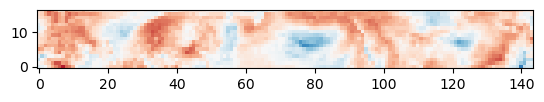

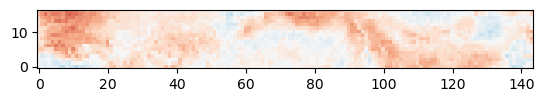

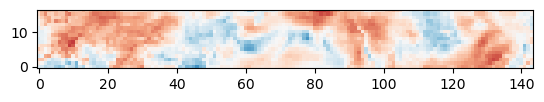

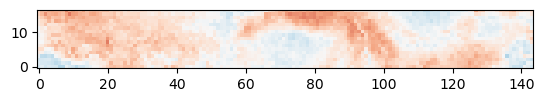

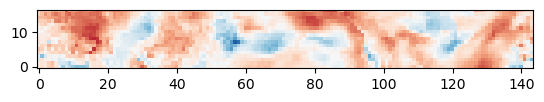

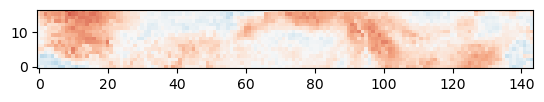

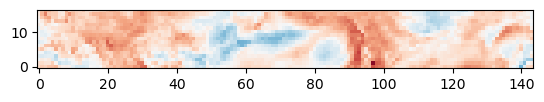

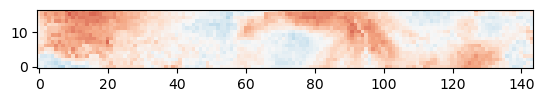

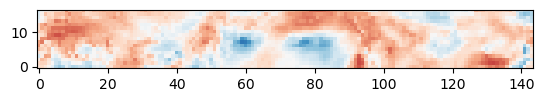

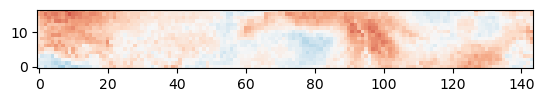

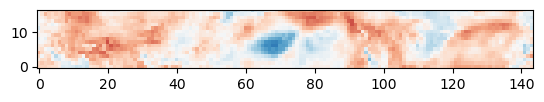

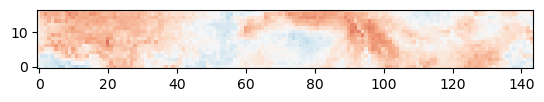

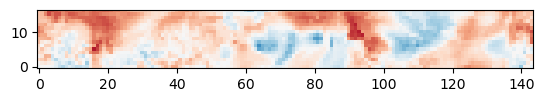

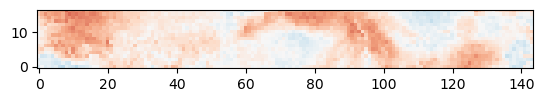

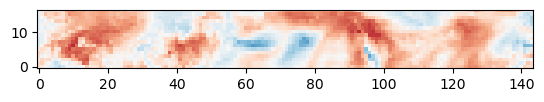

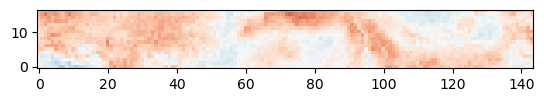

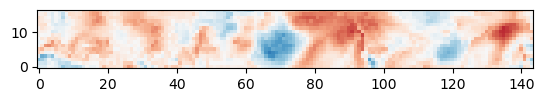

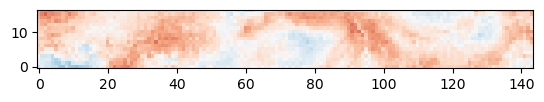

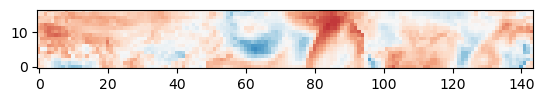

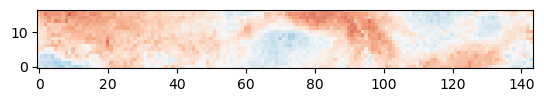

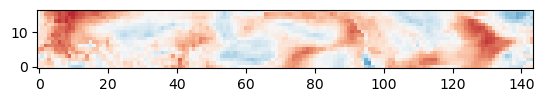

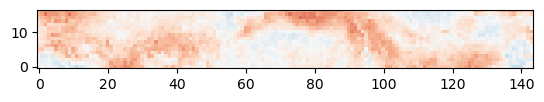

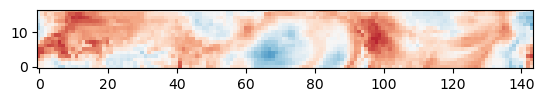

In [38]:
for i in np.arange(0,300,10):
    val_pred_reshape = val_pred[i].reshape((17,144))
    plt.imshow(val_pred_reshape,origin='lower',cmap='RdBu_r',vmin=0,vmax=1)
    plt.show()
    Yval_reshape = Yval[i].reshape((17,144))
    plt.imshow(Yval_reshape,origin='lower',cmap='RdBu_r',vmin=0,vmax=1)
    plt.show()

In [27]:
# for i in np.arange(0,300,10):
#     Yval_reshape = Yval[i].reshape((17,144))
#     plt.imshow(Yval_reshape,origin='lower',cmap='RdBu_r',vmin=0,vmax=1)
#     # plt.colorbar(orientation='horizontal')
#     plt.show()

In [44]:
# isample = 600
# ytrainmax = xtrainmax.sel(lat=slice(29,61)).values
# ytrainmin = xtrainmin.sel(lat=slice(29,61)).values

# val_pred_reshape = val_pred[isample].reshape((17,144))
# val_pred_denorm = (val_pred_reshape*(ytrainmax-ytrainmin)) + ytrainmin

# Yval_reshape = Yval[isample].reshape((17,144))
# Yval_denorm = (Yval_reshape*(ytrainmax-ytrainmin)) + ytrainmin

In [212]:
# compare
# ydiff = val_pred_reshape - Yval_reshape
# plt.imshow(ydiff,origin='lower',cmap='RdBu_r')
# plt.colorbar(orientation='horizontal')

In [227]:
# plt.imshow(val_pred_denorm,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
# plt.colorbar(orientation='horizontal')

In [226]:
# plt.imshow(Yval_denorm,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
# plt.colorbar(orientation='horizontal')

In [215]:
# ydiff_denorm = val_pred_denorm - Yval_denorm
# plt.imshow(ydiff_denorm,origin='lower',cmap='RdBu_r')
# plt.colorbar(orientation='horizontal')